### Evaluación Científico de Datos Jr 

Modelo predictivo que muestre la probabilidad de que un
CLIENTE retire el 70% o más de su saldo en los siguientes 3 meses

-Primer paso
Se realiza la lectura de los saldos y se busca estandarizar la información para un manejo más sencillo de los datos. 
Realizamos una agrupación a nivel ID del cliente para saber su saldo, qué contratos y que productos tiene activos, incluyendo el historial de su saldo mensual

In [1111]:
import pyarrow.parquet as pq
import pandas as pd
from datetime import datetime as dt
import numpy as np

saldos = pq.read_table('0saldos.parquet').to_pandas()
saldos = saldos.loc[saldos['TipoDocum'] == 'C ']
# saldos
# Realizar la agrupación y especificar cómo agregar las columnas utilizando regex
# resultados_agrupados = df.groupby('columna_agrupadora').apply(lambda x: x.filter(regex=regex_a_mantener))

info_por_cliente = saldos.groupby('NroDocum').agg(
    Contrato=('Contrato', list),
    Contratos=('Contrato', list),
    # NumeroContratos=('Contrato', 'count'),
    # NumeroProductos=('PlanProducto', 'count'),
    Productos=('PlanProducto', list),
    **{col: (col, 'sum') for col in saldos.columns if
       col not in ['NroDocum', 'Contrato', 'PlanProducto', 'TipoDocum', 'SALDO_202209']}
).reset_index()
# conteo_contratos_por_cliente['Saldo2022Aug'] = conteo_contratos_por_cliente['Saldo2022Aug'].apply(lambda x: list(set(x)))
info_por_cliente['Productos'] = info_por_cliente['Productos'].apply(lambda x: list(set(x)))

info_por_cliente.head(20)


,NroDocum,Contrato,Contratos,Productos,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,...,SALDO_202112,SALDO_202201,SALDO_202202,SALDO_202203,SALDO_202204,SALDO_202205,SALDO_202206,SALDO_202207,SALDO_202208,SALDO_202210
0,1000001634,[9950268],[9950268],[4899],47092297.99,46315661.29,45229127.61,45298456.10,47140239.11,4.692357e+07,...,5.161528e+07,4.999541e+07,5.090699e+07,4.823857e+07,50249882.12,48430969.50,48976166.48,50399995.40,49148602.10,4.967498e+07
1,1000004345,"[8629082, 6261343, 6133677, 9374655, 5919728]","[8629082, 6261343, 6133677, 9374655, 5919728]","[3376, 8404]",0.00,0.00,0.00,0.00,0.00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.000000e+00
2,1000005362,[6845989],[6845989],[7256],0.00,0.00,0.00,0.00,0.00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.000000e+00
3,1000005396,[5835760],[5835760],[7256],0.00,0.00,0.00,0.00,0.00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.000000e+00
4,1000007479,[2779865],[2779865],[8404],90932411.58,93993197.01,96553396.47,99759806.09,99628363.77,1.088142e+08,...,1.269493e+08,1.304447e+08,1.304298e+08,1.365314e+08,36996395.24,39371555.32,42176765.55,45424357.88,50964795.04,2.548386e+08
5,1000007557,[7095683],[7095683],[7256],0.00,0.00,0.00,0.00,0.00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.000000e+00
6,1000008577,[4620527],[4620527],[6803],0.00,0.00,0.00,0.00,0.00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.000000e+00
7,1000008826,"[2712448, 7337966, 5048101]","[2712448, 7337966, 5048101]",[7256],0.00,0.00,0.00,0.00,0.00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.000000e+00
8,1000009088,[5863862],[5863862],[7256],0.00,0.00,0.00,0.00,0.00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.000000e+00
9,1000009152,[6053184],[6053184],[8404],0.00,0.00,0.00,0.00,0.00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.000000e+00


Ahora leeremos las transferencias, dado que necesitamos el valor neto de las operaciones por mes, agruparemos la información a nivel mes para tener un historial ordenado.

In [1112]:
transferencias = pq.read_table('0transferencias.parquet').to_pandas()
transferencias.drop(
    columns=['Usuario', 'CodDestino', 'CodTipoGiro', 'CodBancoDestinoACH', 'CodBancoSkandia', 'TipoCtaACH', 'TipoOper',
             'EstadoReverso'], inplace=True)
transferencias.sort_values(by='FechaEfectiva', ascending=True, inplace=True)
transferencias.FechaEfectiva = pd.to_datetime(transferencias.FechaEfectiva, format='%Y-%m-%d')

# Agrupar las transacciones por mes y sumar los valores
transferencias = transferencias.groupby(
    [transferencias['Contrato'], transferencias['FechaEfectiva'].dt.to_period('M')], as_index=False
).agg(
    FechaEfectiva=('FechaEfectiva', 'first'),
    ValorTransaccion=('ValorNeto', 'sum'),
    Productos=('PlanProducto', list)
)
transferencias['FechaEfectiva'] = transferencias['FechaEfectiva'].dt.strftime('%Y-%m-01')
transferencias['Productos'] = transferencias['Productos'].apply(lambda x: list(set(x)))
transferencias

transferencias_promedio = transferencias.groupby(
    [transferencias['Contrato']], as_index=False
).agg(
    # FechaEfectiva=('FechaEfectiva', 'first'),
    ValorTransaccion=('ValorTransaccion', 'mean'),
    # Productos=('PlanProducto', list)
)
transferencias_promedio

,Contrato,ValorTransaccion
0,10359,-2.400000e+04
1,11135,1.514032e+08
2,11486,4.206700e+06
3,11595,5.200000e+06
4,11989,-5.500000e+07
...,...,...
23407,9998936,4.387500e+08
23408,9999584,1.449000e+07
23409,9999852,-3.300900e+07
23410,9999884,-3.338484e+07


Al realzar la lectura del registro de clientes, vemos que no coincide con nuestro registro de saldos. Para mantener coherencia en la información eliminaremos las entradas sobrantes.
Realizaremos una fusion entre el dataframe de clientes y saldos. 

In [1113]:

clientes = pq.read_table('0clientes.parquet').to_pandas()
clientes = clientes.loc[clientes['TIPODOCUM'] == 'C']
clientes.drop(
    columns=['EnvioExtractos', 'TIPODOCUM'], inplace=True)

missings = list(set(info_por_cliente.NroDocum.drop_duplicates().values) - set(clientes.NroDocum.values))
print(missings)
mask = clientes['NroDocum'].isin(missings)
clientes = clientes[~mask]

info_por_cliente = info_por_cliente.merge(clientes, how="right", left_on=['NroDocum'], right_on=['NroDocum'])
info_por_cliente.head(10)
# info_por_cliente.loc[info_por_cliente.NroDocum == 1017461995]
# # saldos.drop(
# #     columns=[ 'TIPODOCUM', 'FecNacim_x', 'FecNacim_y'], inplace=True)
# info_por_cliente.head(15)
# info_por_cliente.loc[info_por_cliente.Contrato == 10359]


[1070060609, 1199426185, 1105436267, 1067667956, 1191709847, 1168295676, 1114592927]


,NroDocum,Contrato,Contratos,Productos,SALDO_202101,SALDO_2021O2,SALDO_2021O3,SALDO_2021O4,SALDO_2021O5,SALDO_2021O6,...,SALDO_202202,SALDO_202203,SALDO_202204,SALDO_202205,SALDO_202206,SALDO_202207,SALDO_202208,SALDO_202210,CIUDAD,FecNacim
0,1092070504,[9568209],[9568209],[7256],2160283.24,2141898.30,2108735.19,22159134.02,22120000.31,18148702.83,...,15123192.86,15134221.21,15159658.05,15140299.09,15129302.55,15134704.54,15223124.30,13382658.87,"BOGOTA D.C., BOGOTA",1954-12-16
1,1097627287,"[4287717, 3578135]","[4287717, 3578135]","[7256, 8404]",87443093.98,87471486.70,87011064.12,87222934.80,87119027.32,87263309.38,...,75679112.20,75631903.82,75788485.61,75874782.13,75904347.84,75621538.10,75936631.30,76451290.69,"BOGOTA D.C., BOGOTA",1969-08-04
2,1066619616,[3691242],[3691242],[3376],0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"BOGOTA D.C., BOGOTA",1961-08-15
3,1079454835,"[9062165, 4126838, 3256033, 2004052, 5060811]","[9062165, 4126838, 3256033, 2004052, 5060811]","[7256, 4899]",447349.75,427505.61,402144.49,385543.39,365940.43,347245.96,...,3202636.41,3205011.78,3217378.98,3217829.75,3226585.30,3235574.81,3253485.28,3300591.72,"BOGOTA D.C., BOGOTA",1986-02-08
4,1199126816,"[8498466, 730328]","[8498466, 730328]","[7256, 8404]",315.44,315.70,313.20,319.94,318.57,323.47,...,322.94,325.36,315.42,309.58,293.69,301.28,297.46,298.22,"MEDELLIN, ANTIOQUIA",1981-01-15
5,1092548364,[2388936],[2388936],[7256],0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"BOGOTA D.C., BOGOTA",1967-09-24
6,1017461995,[1775126],[1775126],[3376],0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"BOGOTA D.C., BOGOTA",1944-01-22
7,1038006340,[3237760],[3237760],[1722],0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"BOGOTA D.C., BOGOTA",1956-04-04
8,1056519771,"[3499261, 688553]","[3499261, 688553]",[7256],0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"BUCARAMANGA, SANTANDER",1979-05-10
9,1030081061,[1084467],[1084467],[3376],844091.95,940372.53,1124520.36,1328682.44,1524889.67,1723071.45,...,1014862.91,2212729.06,1711348.26,1903033.08,1294906.10,1470326.32,574456.15,625193.21,"BOGOTA D.C., BOGOTA",1977-04-28


Ahora buscaremos casos donde los clientes han retirado el 70% o más de su saldo en los últimos 3 meses.

In [1114]:
regex = r'^SALDO'


def group_columns_by_regex(row, regex):
    selected_columns = row.filter(regex=regex)
    return selected_columns.tolist()


mask_saldos = info_por_cliente.filter(regex=regex).sum(axis=1).isin([0])
info_por_cliente = info_por_cliente[~mask_saldos]

info_por_cliente['edad'] = info_por_cliente['FecNacim']
info_por_cliente = info_por_cliente.astype({'edad': 'str'})
info_por_cliente['edad'] = info_por_cliente['edad'].str.slice(0, 4)
info_por_cliente = info_por_cliente.astype({'edad': 'int'})
info_por_cliente['edad'] = -(info_por_cliente['edad'] - 2022)

# Detectar casos donde ya han bajado del 70% anteriormente
def has_fallen(y):
    y = [i for i in y if i > 0]
    start = -4
    if len(y) < 4:
        start = -3
    if len(y) < 3:
        start = -2
    if len(y) < 2:
        return False
        
    has_fallen = (y[start] - y[-1] ) >= (y[start] * 0.30)
    return has_fallen




info_por_cliente = pd.merge(info_por_cliente.explode('Contrato'), transferencias_promedio, on='Contrato',
                            how='left').reset_index()

# Agrupar por usuario y sumar los números asociados a los contratos
info_por_cliente['Serie Saldos'] = info_por_cliente.apply(lambda row: group_columns_by_regex(row, regex), axis=1)
info_por_cliente['-70%'] = info_por_cliente['Serie Saldos'].apply(has_fallen)
info_por_cliente.drop(
    columns=['index', 'Contrato'], inplace=True)

info_por_cliente = info_por_cliente.filter(regex=f'^(?!{regex}).*$', axis=1)

info_por_cliente.head(10)

,NroDocum,Contratos,Productos,CIUDAD,FecNacim,edad,ValorTransaccion,Serie Saldos,-70%
0,1092070504,[9568209],[7256],"BOGOTA D.C., BOGOTA",1954-12-16,68,-2.121244e+06,"[2160283.24, 2141898.3, 2108735.19, 22159134.0...",False
1,1097627287,"[4287717, 3578135]","[7256, 8404]","BOGOTA D.C., BOGOTA",1969-08-04,53,NaN,"[87443093.98, 87471486.7, 87011064.12, 8722293...",False
2,1097627287,"[4287717, 3578135]","[7256, 8404]","BOGOTA D.C., BOGOTA",1969-08-04,53,-6.500000e+06,"[87443093.98, 87471486.7, 87011064.12, 8722293...",False
3,1079454835,"[9062165, 4126838, 3256033, 2004052, 5060811]","[7256, 4899]","BOGOTA D.C., BOGOTA",1986-02-08,36,-7.981530e+03,"[447349.75, 427505.61, 402144.49, 385543.39, 3...",False
4,1079454835,"[9062165, 4126838, 3256033, 2004052, 5060811]","[7256, 4899]","BOGOTA D.C., BOGOTA",1986-02-08,36,-2.368445e+05,"[447349.75, 427505.61, 402144.49, 385543.39, 3...",False
5,1079454835,"[9062165, 4126838, 3256033, 2004052, 5060811]","[7256, 4899]","BOGOTA D.C., BOGOTA",1986-02-08,36,-2.044631e+04,"[447349.75, 427505.61, 402144.49, 385543.39, 3...",False
6,1079454835,"[9062165, 4126838, 3256033, 2004052, 5060811]","[7256, 4899]","BOGOTA D.C., BOGOTA",1986-02-08,36,-6.833955e+04,"[447349.75, 427505.61, 402144.49, 385543.39, 3...",False
7,1079454835,"[9062165, 4126838, 3256033, 2004052, 5060811]","[7256, 4899]","BOGOTA D.C., BOGOTA",1986-02-08,36,3.190650e+06,"[447349.75, 427505.61, 402144.49, 385543.39, 3...",False
8,1199126816,"[8498466, 730328]","[7256, 8404]","MEDELLIN, ANTIOQUIA",1981-01-15,41,NaN,"[315.44, 315.7, 313.2, 319.94, 318.57, 323.47,...",False
9,1199126816,"[8498466, 730328]","[7256, 8404]","MEDELLIN, ANTIOQUIA",1981-01-15,41,NaN,"[315.44, 315.7, 313.2, 319.94, 318.57, 323.47,...",False


Haremos una comparativa entre los casos detectados y los negativos para ver si podemos encontrar algún patron.

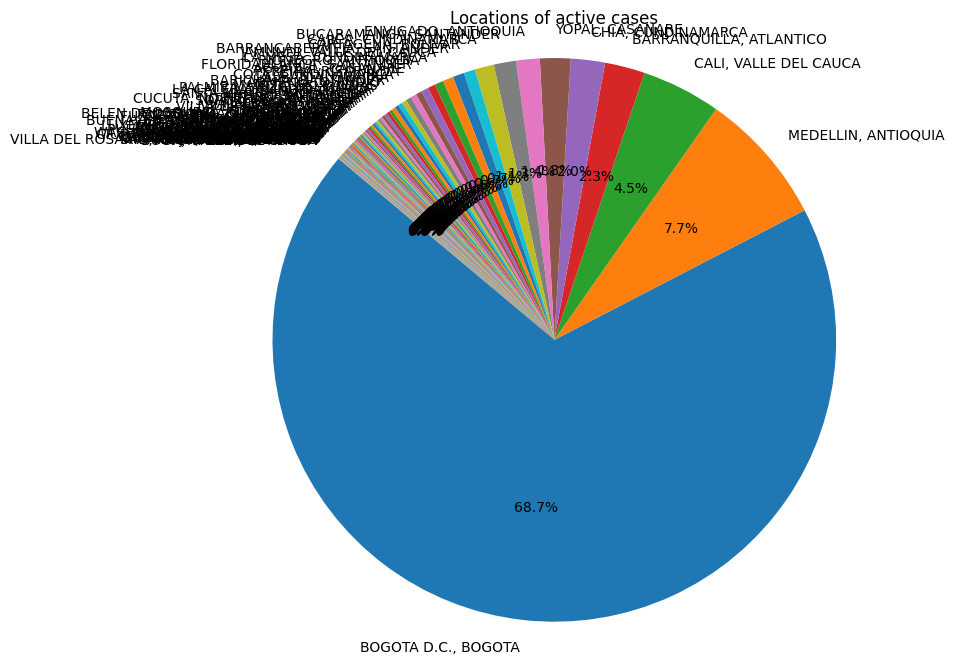

In [1115]:
import matplotlib.pyplot as plt

info_por_cliente.loc[info_por_cliente['ValorTransaccion'] < 0, 'Promedio de transacciones'] = -1
info_por_cliente.loc[info_por_cliente['ValorTransaccion'] > 0, 'Promedio de transacciones'] = 1

casos_activos = info_por_cliente.loc[info_por_cliente['-70%'] == True]
# casos_activos.head(10)

counts = casos_activos['CIUDAD'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title('Locations of active cases')
plt.show()


# Casos registrados

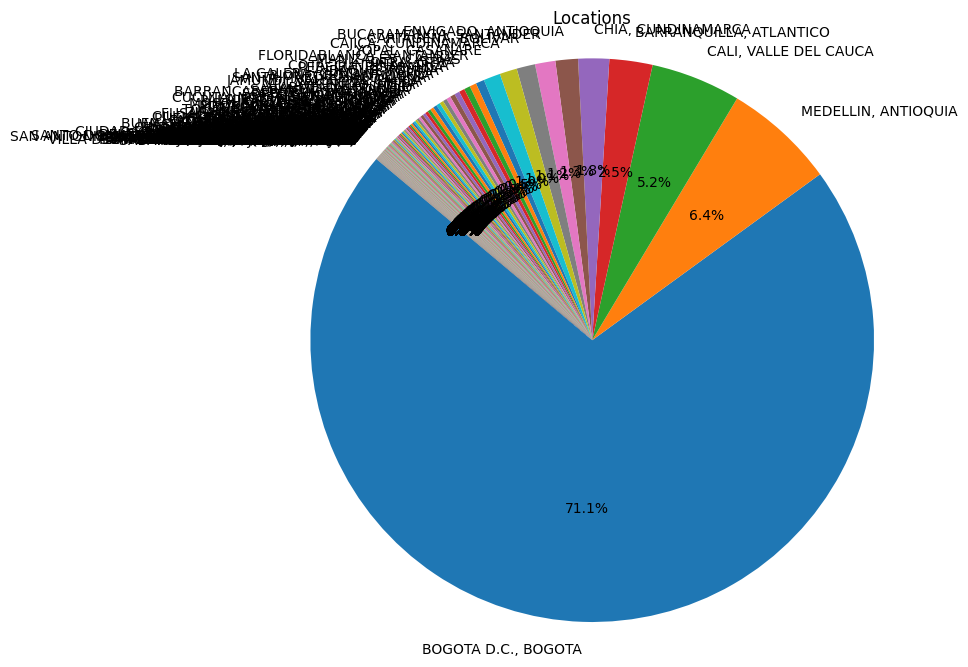

In [1116]:
counts = info_por_cliente['CIUDAD'].value_counts()

# Crea un gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Hace que el gráfico de pastel sea circular
plt.title('Locations')
plt.show()

In [1117]:
porcentaje_de_casos = (len(casos_activos.index.values)) / ((len(info_por_cliente.index.values)) * 0.01)
print(str(porcentaje_de_casos) + ' %')


9.574116374128396 %


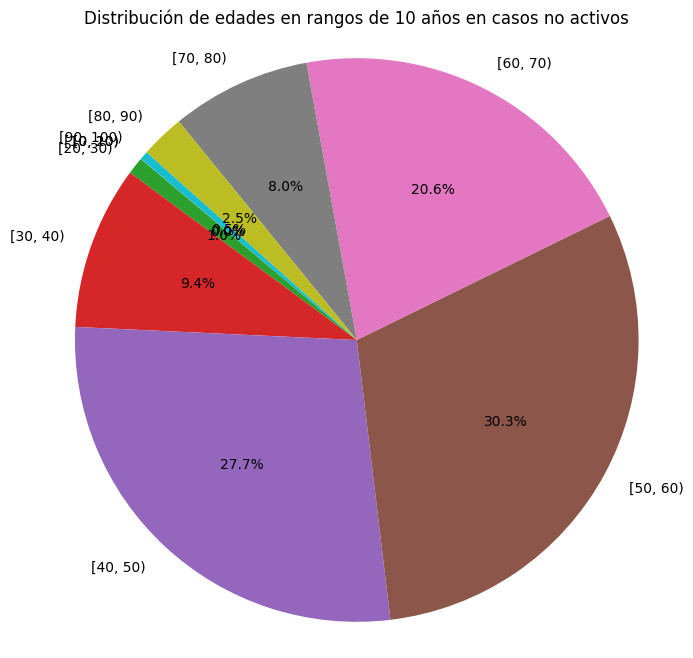

In [1118]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

age_groups = pd.cut(info_por_cliente['edad'], bins=bins, right=False)
age_group_counts = age_groups.value_counts().sort_index()

# Creamos la gráfica de pastel
plt.figure(figsize=(8, 8))
plt.pie(age_group_counts, labels=age_group_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Hace que el gráfico de pastel sea circular
plt.title('Distribución de edades en rangos de 10 años en casos no activos')
plt.show()

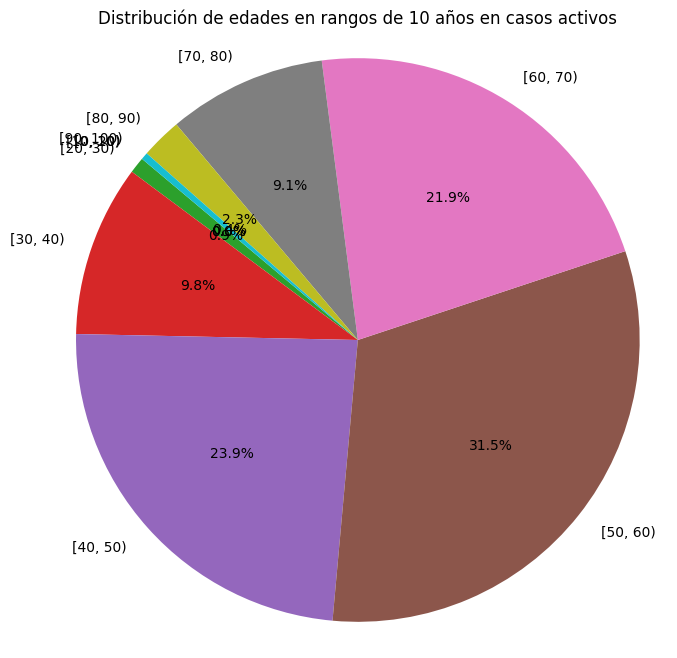

In [1119]:
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

age_groups = pd.cut(casos_activos['edad'], bins=bins, right=False)
age_group_counts = age_groups.value_counts().sort_index()

# Creamos la gráfica de pastel
plt.figure(figsize=(8, 8))
plt.pie(age_group_counts, labels=age_group_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Hace que el gráfico de pastel sea circular
plt.title('Distribución de edades en rangos de 10 años en casos activos')
plt.show()

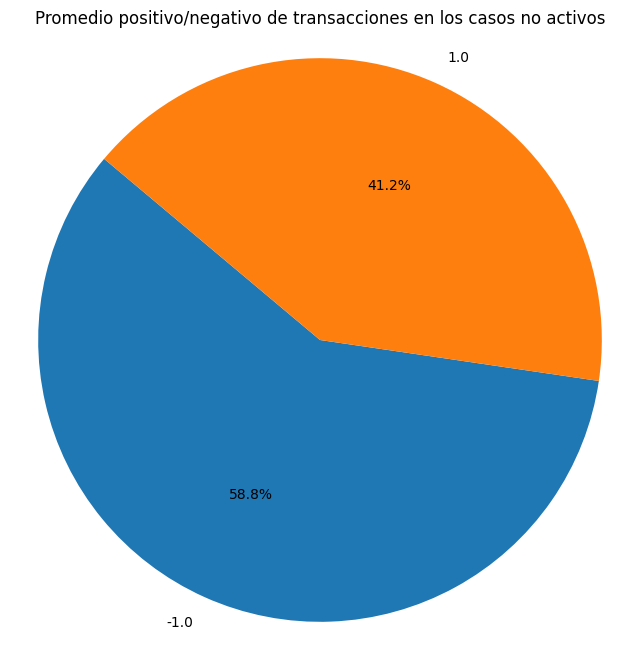

In [1120]:
counts = info_por_cliente['Promedio de transacciones'].value_counts()

# Crea un gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Hace que el gráfico de pastel sea circular
plt.title('Promedio positivo/negativo de transacciones en los casos no activos')
plt.show()

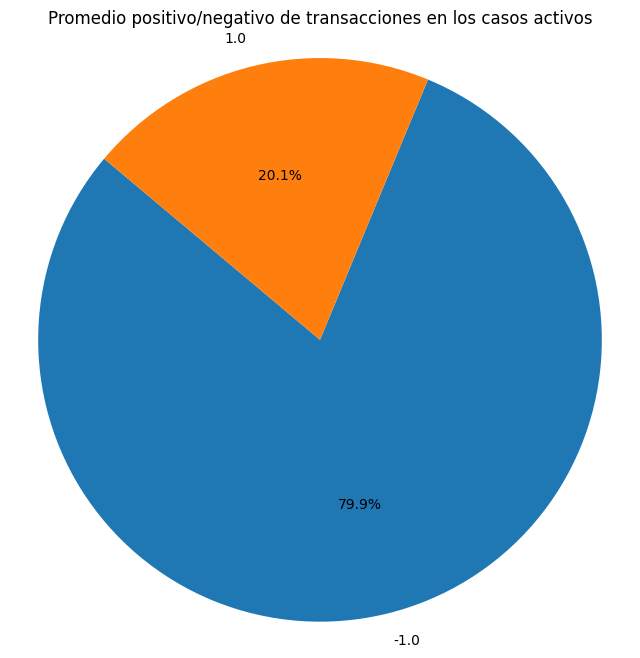

In [1121]:
counts = casos_activos['Promedio de transacciones'].value_counts()

# Crea un gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Hace que el gráfico de pastel sea circular
plt.title('Promedio positivo/negativo de transacciones en los casos activos')
plt.show()

Vemos que unicamente el promedio de transacciones puede ser un patron para detectar casos nuevos. 

In [1122]:
info_por_cliente.head(10)

,NroDocum,Contratos,Productos,CIUDAD,FecNacim,edad,ValorTransaccion,Serie Saldos,-70%,Promedio de transacciones
0,1092070504,[9568209],[7256],"BOGOTA D.C., BOGOTA",1954-12-16,68,-2.121244e+06,"[2160283.24, 2141898.3, 2108735.19, 22159134.0...",False,-1.0
1,1097627287,"[4287717, 3578135]","[7256, 8404]","BOGOTA D.C., BOGOTA",1969-08-04,53,NaN,"[87443093.98, 87471486.7, 87011064.12, 8722293...",False,NaN
2,1097627287,"[4287717, 3578135]","[7256, 8404]","BOGOTA D.C., BOGOTA",1969-08-04,53,-6.500000e+06,"[87443093.98, 87471486.7, 87011064.12, 8722293...",False,-1.0
3,1079454835,"[9062165, 4126838, 3256033, 2004052, 5060811]","[7256, 4899]","BOGOTA D.C., BOGOTA",1986-02-08,36,-7.981530e+03,"[447349.75, 427505.61, 402144.49, 385543.39, 3...",False,-1.0
4,1079454835,"[9062165, 4126838, 3256033, 2004052, 5060811]","[7256, 4899]","BOGOTA D.C., BOGOTA",1986-02-08,36,-2.368445e+05,"[447349.75, 427505.61, 402144.49, 385543.39, 3...",False,-1.0
5,1079454835,"[9062165, 4126838, 3256033, 2004052, 5060811]","[7256, 4899]","BOGOTA D.C., BOGOTA",1986-02-08,36,-2.044631e+04,"[447349.75, 427505.61, 402144.49, 385543.39, 3...",False,-1.0
6,1079454835,"[9062165, 4126838, 3256033, 2004052, 5060811]","[7256, 4899]","BOGOTA D.C., BOGOTA",1986-02-08,36,-6.833955e+04,"[447349.75, 427505.61, 402144.49, 385543.39, 3...",False,-1.0
7,1079454835,"[9062165, 4126838, 3256033, 2004052, 5060811]","[7256, 4899]","BOGOTA D.C., BOGOTA",1986-02-08,36,3.190650e+06,"[447349.75, 427505.61, 402144.49, 385543.39, 3...",False,1.0
8,1199126816,"[8498466, 730328]","[7256, 8404]","MEDELLIN, ANTIOQUIA",1981-01-15,41,NaN,"[315.44, 315.7, 313.2, 319.94, 318.57, 323.47,...",False,NaN
9,1199126816,"[8498466, 730328]","[7256, 8404]","MEDELLIN, ANTIOQUIA",1981-01-15,41,NaN,"[315.44, 315.7, 313.2, 319.94, 318.57, 323.47,...",False,NaN


In [1123]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PoissonRegressor
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.linear_model import LinearRegression
import math
# Supongamos que tienes una serie temporal


# Crea un array con los índices de tiempo
def tendencia(serie_temporal):
    serie_temporal = [i for i in serie_temporal if i > 0]
    serie_temporal  = [0 if math.isnan(x) else x for x in serie_temporal]

    start = -5
    if len(serie_temporal) < 5:
        start = -4
    if len(serie_temporal) < 4:
        start = -3
    if len(serie_temporal) < 3:
        start = -2


    serie_temporal = serie_temporal[start:]
        
    tiempo = np.arange(len(serie_temporal)).reshape(-1, 1)

    # Ajusta una regresión lineal
    modelo = LinearRegression()
    modelo.fit(tiempo, serie_temporal)
    
    # Obtiene el coeficiente de la pendiente
    pendiente = modelo.coef_[0]
    return pendiente


def drop_percent(y):
    start = -5
    if len(y) < 5:
        start = -4
    if len(y) < 4:
        start = -3
    if len(y) < 3:
        start = -2


    try:
        porcentaje_caida = ((y[-1]) / (y[start] * 0.01)) - 100
    except:
        return np.nan
    return porcentaje_caida


info_por_cliente.fillna({'Promedio de transacciones': 0}, inplace=True)
info_por_cliente.fillna({'ValorTransaccion': 0}, inplace=True)

# Aplicamos la función a cada lista en la columna 'serie_temporal' y almacenamos los resultados en una nueva columna
info_por_cliente['caida'] = info_por_cliente['Serie Saldos'].apply(drop_percent)
info_por_cliente['tendencia'] = info_por_cliente['Serie Saldos'].apply(tendencia)
def drop_ceros(y):
    return [i for i in y if i != 0]

info_por_cliente['Serie Saldos'] = info_por_cliente['Serie Saldos'].apply(drop_ceros)
info_por_cliente = info_por_cliente[info_por_cliente['Serie Saldos'].apply(lambda x: len(x) > 0)]
info_por_cliente.dropna(subset=['tendencia'], inplace=True)
info_por_cliente.dropna(subset=['caida'], inplace=True)

In [1124]:
info_por_cliente.head(10)

,NroDocum,Contratos,Productos,CIUDAD,FecNacim,edad,ValorTransaccion,Serie Saldos,-70%,Promedio de transacciones,caida,tendencia
0,1092070504,[9568209],[7256],"BOGOTA D.C., BOGOTA",1954-12-16,68,-2.121244e+06,"[2160283.24, 2141898.3, 2108735.19, 22159134.0...",False,-1.0,-11.609019,-342145.869
1,1097627287,"[4287717, 3578135]","[7256, 8404]","BOGOTA D.C., BOGOTA",1969-08-04,53,0.000000e+00,"[87443093.98, 87471486.7, 87011064.12, 8722293...",False,0.0,0.759816,118530.058
2,1097627287,"[4287717, 3578135]","[7256, 8404]","BOGOTA D.C., BOGOTA",1969-08-04,53,-6.500000e+06,"[87443093.98, 87471486.7, 87011064.12, 8722293...",False,-1.0,0.759816,118530.058
3,1079454835,"[9062165, 4126838, 3256033, 2004052, 5060811]","[7256, 4899]","BOGOTA D.C., BOGOTA",1986-02-08,36,-7.981530e+03,"[447349.75, 427505.61, 402144.49, 385543.39, 3...",False,-1.0,2.571981,19242.392
4,1079454835,"[9062165, 4126838, 3256033, 2004052, 5060811]","[7256, 4899]","BOGOTA D.C., BOGOTA",1986-02-08,36,-2.368445e+05,"[447349.75, 427505.61, 402144.49, 385543.39, 3...",False,-1.0,2.571981,19242.392
5,1079454835,"[9062165, 4126838, 3256033, 2004052, 5060811]","[7256, 4899]","BOGOTA D.C., BOGOTA",1986-02-08,36,-2.044631e+04,"[447349.75, 427505.61, 402144.49, 385543.39, 3...",False,-1.0,2.571981,19242.392
6,1079454835,"[9062165, 4126838, 3256033, 2004052, 5060811]","[7256, 4899]","BOGOTA D.C., BOGOTA",1986-02-08,36,-6.833955e+04,"[447349.75, 427505.61, 402144.49, 385543.39, 3...",False,-1.0,2.571981,19242.392
7,1079454835,"[9062165, 4126838, 3256033, 2004052, 5060811]","[7256, 4899]","BOGOTA D.C., BOGOTA",1986-02-08,36,3.190650e+06,"[447349.75, 427505.61, 402144.49, 385543.39, 3...",False,1.0,2.571981,19242.392
8,1199126816,"[8498466, 730328]","[7256, 8404]","MEDELLIN, ANTIOQUIA",1981-01-15,41,0.000000e+00,"[315.44, 315.7, 313.2, 319.94, 318.57, 323.47,...",False,0.0,-3.669488,-1.895
9,1199126816,"[8498466, 730328]","[7256, 8404]","MEDELLIN, ANTIOQUIA",1981-01-15,41,0.000000e+00,"[315.44, 315.7, 313.2, 319.94, 318.57, 323.47,...",False,0.0,-3.669488,-1.895


In [1125]:
casos_activos = info_por_cliente.loc[info_por_cliente['-70%'] == True]

casos_activos.head(10)

,NroDocum,Contratos,Productos,CIUDAD,FecNacim,edad,ValorTransaccion,Serie Saldos,-70%,Promedio de transacciones,caida,tendencia
10,1030081061,[1084467],[3376],"BOGOTA D.C., BOGOTA",1977-04-28,45,-2.954545e+04,"[844091.95, 940372.53, 1124520.36, 1328682.44,...",True,-1.0,-67.147538,-3.276130e+05
127,1031059898,"[9089120, 6091816]","[4899, 5172]","CUCUTA, NORTE DE SANTANDER",1968-11-16,54,-1.650710e+06,"[102170558.81, 101029905.33000001, 87690003.05...",True,-1.0,-67.689283,-3.899172e+07
128,1031059898,"[9089120, 6091816]","[4899, 5172]","CUCUTA, NORTE DE SANTANDER",1968-11-16,54,-4.413788e+05,"[102170558.81, 101029905.33000001, 87690003.05...",True,-1.0,-67.689283,-3.899172e+07
173,1042632231,"[2931689, 5093096, 7702882, 1401584]","[3376, 4899, 7256]","TABIO, CUNDINAMARCA",1960-07-19,62,0.000000e+00,"[267436591.42000002, 266881082.74, 262080869.2...",True,0.0,-61.245658,-4.784943e+07
174,1042632231,"[2931689, 5093096, 7702882, 1401584]","[3376, 4899, 7256]","TABIO, CUNDINAMARCA",1960-07-19,62,-4.000000e+07,"[267436591.42000002, 266881082.74, 262080869.2...",True,-1.0,-61.245658,-4.784943e+07
175,1042632231,"[2931689, 5093096, 7702882, 1401584]","[3376, 4899, 7256]","TABIO, CUNDINAMARCA",1960-07-19,62,0.000000e+00,"[267436591.42000002, 266881082.74, 262080869.2...",True,0.0,-61.245658,-4.784943e+07
176,1042632231,"[2931689, 5093096, 7702882, 1401584]","[3376, 4899, 7256]","TABIO, CUNDINAMARCA",1960-07-19,62,-1.100000e+08,"[267436591.42000002, 266881082.74, 262080869.2...",True,-1.0,-61.245658,-4.784943e+07
324,1152436264,"[9960561, 9740093]","[4899, 5172]","JAMUNDI, VALLE DEL CAUCA",1972-04-15,50,0.000000e+00,"[61932458.5, 61908282.86, 61445659.8, 61630123...",True,0.0,-44.532101,-6.101777e+06
325,1152436264,"[9960561, 9740093]","[4899, 5172]","JAMUNDI, VALLE DEL CAUCA",1972-04-15,50,-3.052720e+06,"[61932458.5, 61908282.86, 61445659.8, 61630123...",True,-1.0,-44.532101,-6.101777e+06
416,1079400107,"[7752476, 3011240]","[4899, 8404]","JAMUNDI, VALLE DEL CAUCA",1965-03-15,57,0.000000e+00,"[46767423.18, 36787075.46, 21619070.83, 216650...",True,0.0,-65.066902,-1.329946e+06


In [1126]:
from sklearn.metrics import classification_report, confusion_matrix

def drop_relation(y):
    y = y[:-3]
    y = [i for i in y if i > 0]

    start = -4
    if len(y) < 4:
        start = -3
    if len(y) < 3:
        start = -2
        
    try:
        has_fallen = (y[start] - y[-1] ) >= (y[start] * 0.5)
    except:
        return np.nan
    return has_fallen

def predictions(serie_temporal):
    try:
        serie = pd.Series(serie_temporal)

# Calcula el promedio móvil con una ventana de tamaño window_size
        window_size = 4
        serie_temporal = serie.rolling(window=window_size).mean().dropna().values
        serie_temporal = serie_temporal[-6:]
        
        serie_temporal = [i for i in serie_temporal if i > 0]
        tiempo = np.arange(len(serie_temporal)).reshape(-1, 1)
        # Crea y ajusta un modelo de regresión lineal
        modelo = LinearRegression()
        modelo.fit(tiempo, serie_temporal)
        # Hacer predicciones para los siguientes tres valores
        siguientes_tres_valores = np.array( [ [len(serie_temporal)], [len(serie_temporal) + 1], [len(serie_temporal) + 2] ])
        
        predicciones = list((modelo.predict(siguientes_tres_valores)))
        
        predict_1 = ( predicciones[-1] ) < (serie_temporal[-1] * 0.6)
        predict_2 = (predicciones[-2] ) < (serie_temporal[-1] * 0.6)
        predict_3 = ( predicciones[-3] ) < (serie_temporal[-1] * 0.6)
        if predict_1 or predict_2 or predict_3:
            # return [predicciones, (serie_temporal[-1] * 0.6), serie_temporal]
            return True
        else:
            False
    except:
        return np.nan


In [1127]:
# info_por_cliente['drop relation'] = info_por_cliente['Serie Saldos'].apply(drop_relation)
info_por_cliente['prediction -70%'] = info_por_cliente['Serie Saldos'].apply(predictions)
# info_por_cliente.dropna(subset=['drop relation'], inplace=True)
info_por_cliente.dropna(subset=['prediction -70%'], inplace=True)

In [1128]:
info_por_cliente.loc[ info_por_cliente['-70%'] == False  ].head(10)

,NroDocum,Contratos,Productos,CIUDAD,FecNacim,edad,ValorTransaccion,Serie Saldos,-70%,Promedio de transacciones,caida,tendencia,prediction -70%
34,1103329651,[7068798],[8404],"CALI, VALLE DEL CAUCA",1950-02-14,72,-4.900935e+07,"[125883084.6, 125308833.96, 123733222.54, 1242...",False,-1.0,-57.825182,-7.644977e+06,True
83,1072553247,"[8414135, 9036796, 5939521, 488667]",[3376],"CALI, VALLE DEL CAUCA",1958-04-21,64,-7.500000e+06,"[21826315.47, 21667390.14, 21107942.29, 212950...",False,-1.0,-51.798804,-1.127007e+06,True
84,1072553247,"[8414135, 9036796, 5939521, 488667]",[3376],"CALI, VALLE DEL CAUCA",1958-04-21,64,0.000000e+00,"[21826315.47, 21667390.14, 21107942.29, 212950...",False,0.0,-51.798804,-1.127007e+06,True
85,1072553247,"[8414135, 9036796, 5939521, 488667]",[3376],"CALI, VALLE DEL CAUCA",1958-04-21,64,0.000000e+00,"[21826315.47, 21667390.14, 21107942.29, 212950...",False,0.0,-51.798804,-1.127007e+06,True
86,1072553247,"[8414135, 9036796, 5939521, 488667]",[3376],"CALI, VALLE DEL CAUCA",1958-04-21,64,0.000000e+00,"[21826315.47, 21667390.14, 21107942.29, 212950...",False,0.0,-51.798804,-1.127007e+06,True
273,1090154703,"[6636614, 9928720]","[4899, 8404]",None,1973-06-26,49,-1.818000e+04,"[734198.3, 340060.97, 331066.37, 331820.839999...",False,-1.0,-53.209459,-2.851308e+06,True
274,1090154703,"[6636614, 9928720]","[4899, 8404]",None,1973-06-26,49,1.423000e+06,"[734198.3, 340060.97, 331066.37, 331820.839999...",False,1.0,-53.209459,-2.851308e+06,True
371,1090365328,"[6416944, 1470280, 2401557, 6333640, 6029768, ...","[4899, 3376, 8404, 5172, 7256]","BOGOTA D.C., BOGOTA",1973-10-27,49,0.000000e+00,"[140932825.54, 999605.58, 1975439.35, 2979421....",False,0.0,-93.167057,-5.863072e+07,True
372,1090365328,"[6416944, 1470280, 2401557, 6333640, 6029768, ...","[4899, 3376, 8404, 5172, 7256]","BOGOTA D.C., BOGOTA",1973-10-27,49,0.000000e+00,"[140932825.54, 999605.58, 1975439.35, 2979421....",False,0.0,-93.167057,-5.863072e+07,True
373,1090365328,"[6416944, 1470280, 2401557, 6333640, 6029768, ...","[4899, 3376, 8404, 5172, 7256]","BOGOTA D.C., BOGOTA",1973-10-27,49,0.000000e+00,"[140932825.54, 999605.58, 1975439.35, 2979421....",False,0.0,-93.167057,-5.863072e+07,True


In [1135]:
caida = np.array(info_por_cliente['caida'].values)
tendencia = np.array(info_por_cliente['tendencia'].values)
promedio_de_transacciones = np.array(info_por_cliente['ValorTransaccion'].values)
# past_percent = np.array(info_por_cliente['drop relation'].values)
predict = np.array(info_por_cliente['prediction -70%'].values)
drop = np.array(info_por_cliente['-70%'].values)

# Dividir los datos en conjuntos de entrenamiento y prueba
X = np.column_stack((
    caida,
    tendencia,
    predict
))  # Apilamos las variables predictoras

X_train, X_test, y_train, y_test = train_test_split(X, drop, test_size=0.3, random_state=4)

# Crear el modelo de regresión logística
modelo = LogisticRegressionCV(cv=4)

# Entrenar el modelo
modelo.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
probabilidades = modelo.predict_proba(X)
predicciones = modelo.predict(X_test)
# Calcular la precisión del modelo


reporte_clasificacion = classification_report(y_test, predicciones)

print("Reporte de clasificación:\n", reporte_clasificacion)

# Obtener la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
print("Matriz de confusión:\n", matriz_confusion)

Reporte de clasificación:
               precision    recall  f1-score   support

       False       0.95      0.68      0.79      1017
        True       0.61      0.93      0.74       540

    accuracy                           0.77      1557
   macro avg       0.78      0.81      0.76      1557
weighted avg       0.83      0.77      0.77      1557

Matriz de confusión:
 [[691 326]
 [ 36 504]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  args = (X, target, sample_weight, l2_reg_strength, n_threads)


Aquí ya hemos generado la información para el entrenamiento e imprimido las métricas de rendimiento de nuestro modelo para evaluar y hacer ajustes. 

In [1136]:
final_df = info_por_cliente.copy()
probabilidades = [ i[-1] for i in list(probabilidades)]
final_df['probabilidad de retirar 70%'] = probabilidades
final_df['probabilidad de retirar 70%'] = final_df['probabilidad de retirar 70%'] * 100
final_df.drop(
    columns=['Serie Saldos', 'Promedio de transacciones', '-70%', 'ValorTransaccion', 'prediction -70%'], inplace=True)

In [1137]:
final_df.head(10)

,NroDocum,Contratos,Productos,CIUDAD,FecNacim,edad,caida,tendencia,probabilidad de retirar 70%
34,1103329651,[7068798],[8404],"CALI, VALLE DEL CAUCA",1950-02-14,72,-57.825182,-7.644977e+06,54.510356
83,1072553247,"[8414135, 9036796, 5939521, 488667]",[3376],"CALI, VALLE DEL CAUCA",1958-04-21,64,-51.798804,-1.127007e+06,52.160039
84,1072553247,"[8414135, 9036796, 5939521, 488667]",[3376],"CALI, VALLE DEL CAUCA",1958-04-21,64,-51.798804,-1.127007e+06,52.160039
85,1072553247,"[8414135, 9036796, 5939521, 488667]",[3376],"CALI, VALLE DEL CAUCA",1958-04-21,64,-51.798804,-1.127007e+06,52.160039
86,1072553247,"[8414135, 9036796, 5939521, 488667]",[3376],"CALI, VALLE DEL CAUCA",1958-04-21,64,-51.798804,-1.127007e+06,52.160039
127,1031059898,"[9089120, 6091816]","[4899, 5172]","CUCUTA, NORTE DE SANTANDER",1968-11-16,54,-67.689283,-3.899172e+07,61.559976
128,1031059898,"[9089120, 6091816]","[4899, 5172]","CUCUTA, NORTE DE SANTANDER",1968-11-16,54,-67.689283,-3.899172e+07,61.559976
173,1042632231,"[2931689, 5093096, 7702882, 1401584]","[3376, 4899, 7256]","TABIO, CUNDINAMARCA",1960-07-19,62,-61.245658,-4.784943e+07,61.622696
174,1042632231,"[2931689, 5093096, 7702882, 1401584]","[3376, 4899, 7256]","TABIO, CUNDINAMARCA",1960-07-19,62,-61.245658,-4.784943e+07,61.622696
175,1042632231,"[2931689, 5093096, 7702882, 1401584]","[3376, 4899, 7256]","TABIO, CUNDINAMARCA",1960-07-19,62,-61.245658,-4.784943e+07,61.622696


Finalmente hemos generamos un dataframe a nivel cliente que indica la probabilidad de retirar más del 70% del su saldo en los próximos tres meses.
Las métricas del modelo son apenas aceptables, pero es funcional, y puede mejorar aumentando la calidad de los datos de entrada. 